In [2]:
pip install astroquery

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import astropy.units as u
import astropy.constants as c

from astropy.coordinates import SkyCoord
from astropy.time import Time

import pandas as pd                          # I/O of data in table format
from astroquery.jplhorizons import Horizons  # python interface to HORIZONS

from tqdm.autonotebook import tqdm as tqdm

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline





/tmp/ipykernel_61095/2097400657.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd                          # I/O of data in table format
/tmp/ipykernel_61095/2097400657.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm


In [4]:
data_path = './'
scw_file = 'ScwDB_reduced_0016-2704.fits'# Housekeeping file, containing all the data that we need from Integral.


In [5]:
#Getting the info from the file
scw = fits.open(data_path+scw_file)
scw.info()

Filename: ./ScwDB_reduced_0016-2704.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   194801R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


In [6]:
# looking into the pointing distribution:
ra_sc = scw[1].data['RA_SCX']
dec_sc = scw[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc = SkyCoord(ra=ra_sc,dec=dec_sc,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc = coords_sc.galactic.l.value
# converting from 0..360 to -180..180
lon_sc[lon_sc > 180] -= 360
lat_sc = coords_sc.galactic.b.value
revs = scw[1].data['OrbitRevFrac']
revs_unit = scw[1].columns['OrbitRevFrac'].unit

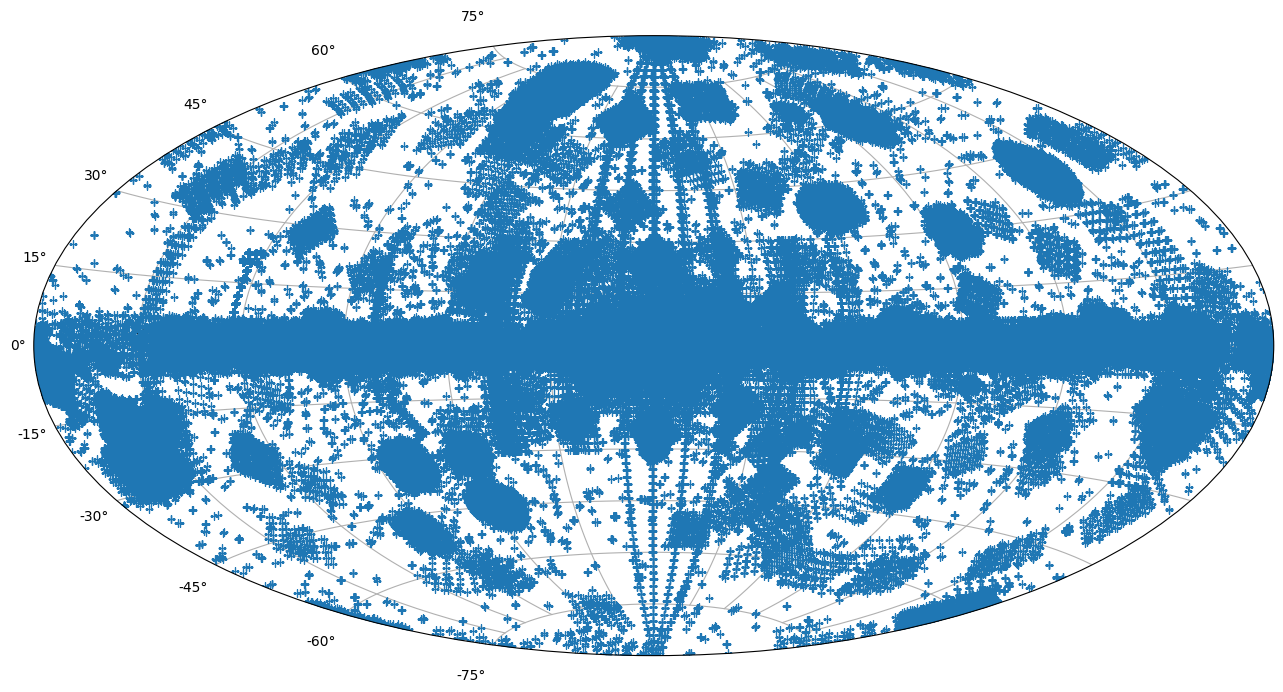

In [7]:
# plotting the coordinates
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+')
plt.grid()

In [9]:
# Now we want to see which of the pointings are in the area where the object we want to study is located.
# We set the fov of SPI equal to 16
fov_threshold = 16.

# We also need to calculate the angular distance of each pointing to the object. We do this using:
# we need to calculate the angular distance of each pointing to the Crab, which
# can be done by the following functions

def GreatCircle(l1,b1,l2,b2,deg=True):

    if deg == True:
        l1,b1,l2,b2 = np.deg2rad(l1),np.deg2rad(b1),np.deg2rad(l2),np.deg2rad(b2)

    return np.sin(b1)*np.sin(b2) + np.cos(b1)*np.cos(b2)*np.cos(l1-l2)



def angular_distance(l1,b1,l2,b2,deg=True):
    """
    Calculate angular distance on a sphere from longitude/latitude pairs to other using Great circles
    """
    gc = GreatCircle(l1,b1,l2,b2,deg=deg)

    if gc.size == 1:
        if gc > 1:
            gc = 1.
    else:
        gc[np.where(gc > 1)] = 1.

    return np.rad2deg(np.arccos(gc))

In [15]:
# Initialize an empty list to store ephemerides data
jupiter_eph_list = []
jupiter_eph_df = pd.DataFrame()

# Define the parameters for the query
start_date = '2003-01-01'
stop_date = '2023-12-31'

# Loop through each year
current_year = int(start_date[:4])
current_year = int(start_date[:4])
while current_year <= int(stop_date[:4]):
    # Define the start and stop dates for the current year
    year_start_date = f"{current_year}-01-01"
    year_stop_date = f"{current_year}-12-31"

    # Define the parameters for the query
    obj = Horizons(id='5', id_type='majorbody',
                   location='500@-198',
                   epochs={'start': year_start_date,
                           'stop': year_stop_date,
                           'step': '15min'})  # Step size remains as 1 hour
    print(current_year)

    # Perform the query to retrieve ephemerides data
    try:
        jupiter_eph = obj.ephemerides()
        jupiter_eph_df = jupiter_eph_df.append(jupiter_eph.to_pandas(), ignore_index=True)
    except ValueError as e:
        print(f"Error fetching data for {year_start_date} to {year_stop_date}: {e}")

    current_year += 1

# Concatenate the list of ephemerides data into a single DataFrame
#jupiter_eph_df = pd.concat(jupiter_eph_list, ignore_index=True)

2003


KeyboardInterrupt: 

In [94]:
# Define the parameters for the query
obj = Horizons(id='5', id_type='majorbody',
                    location='500@-198',
                    epochs={'start': '2002-10-18',
                            'stop': '2002-12-31',
                            'step': '1h'})  # Step size remains as 1 hour

jupiter_eph_2002 = obj.ephemerides()
jupiter_eph_df_2002 = jupiter_eph_2002.to_pandas
jupiter_eph_df_2002

<bound method Table.to_pandas of <Table masked=True length=1777>
      targetname          datetime_str      datetime_jd    ...  PABLon   PABLat
         ---                  ---                d         ...   deg      deg  
        str22                str17            float64      ... float64  float64
---------------------- ----------------- ----------------- ... -------- -------
Jupiter Barycenter (5) 2002-Oct-18 00:00         2452565.5 ... 129.5536  0.5146
Jupiter Barycenter (5) 2002-Oct-18 01:00 2452565.541666667 ...  129.558  0.5146
Jupiter Barycenter (5) 2002-Oct-18 02:00 2452565.583333333 ... 129.5624  0.5146
Jupiter Barycenter (5) 2002-Oct-18 03:00       2452565.625 ... 129.5668  0.5146
Jupiter Barycenter (5) 2002-Oct-18 04:00 2452565.666666667 ... 129.5713  0.5147
Jupiter Barycenter (5) 2002-Oct-18 05:00 2452565.708333333 ... 129.5757  0.5147
Jupiter Barycenter (5) 2002-Oct-18 06:00        2452565.75 ... 129.5801  0.5147
Jupiter Barycenter (5) 2002-Oct-18 07:00 2452565.791666

In [92]:
jupiter_eph_df

,targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,Jupiter Barycenter (5),2003-Jan-01 00:00,2.452640e+06,,,139.53094,16.51298,139.53551,16.51145,-11.97860,...,<NA>,<NA>,<NA>,<NA>,<NA>,114.5322,<NA>,6.3664,133.6567,0.7064
1,Jupiter Barycenter (5),2003-Jan-01 01:00,2.452641e+06,,,139.52748,16.51434,139.53204,16.51280,-11.94360,...,<NA>,<NA>,<NA>,<NA>,<NA>,114.5356,<NA>,6.3595,133.6566,0.7066
2,Jupiter Barycenter (5),2003-Jan-01 02:00,2.452641e+06,,,139.52402,16.51571,139.52858,16.51417,-11.90730,...,<NA>,<NA>,<NA>,<NA>,<NA>,114.5389,<NA>,6.3526,133.6565,0.7068
3,Jupiter Barycenter (5),2003-Jan-01 03:00,2.452641e+06,,,139.52058,16.51710,139.52513,16.51554,-11.86970,...,<NA>,<NA>,<NA>,<NA>,<NA>,114.5423,<NA>,6.3457,133.6564,0.7070
4,Jupiter Barycenter (5),2003-Jan-01 04:00,2.452641e+06,,,139.51714,16.51850,139.52169,16.51693,-11.83040,...,<NA>,<NA>,<NA>,<NA>,<NA>,114.5457,<NA>,6.3388,133.6563,0.7072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183592,Jupiter Barycenter (5),2023-Dec-30 20:00,2.460309e+06,,,33.36136,12.13224,33.36391,12.13304,-0.44305,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8165,<NA>,10.1518,40.3163,-1.1418
183593,Jupiter Barycenter (5),2023-Dec-30 21:00,2.460309e+06,,,33.36124,12.13237,33.36379,12.13316,-0.41788,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8202,<NA>,10.1556,40.3181,-1.1417
183594,Jupiter Barycenter (5),2023-Dec-30 22:00,2.460309e+06,,,33.36113,12.13252,33.36367,12.13330,-0.39269,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8239,<NA>,10.1594,40.3200,-1.1416
183595,Jupiter Barycenter (5),2023-Dec-30 23:00,2.460309e+06,,,33.36102,12.13270,33.36355,12.13346,-0.36748,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8277,<NA>,10.1632,40.3219,-1.1415


In [ ]:

#Getting the relevant coordinates and dates for these coordinates for Jupiter in the requested time span

gl_jupiter = jupiter_eph_df['GlxLon'].values # galactic longtitude
gl_jupiter[gl_jupiter>180] -= 360
gb_jupiter = jupiter_eph_df['GlxLat'].values # galactic latitude
jd_jupiter = jupiter_eph_df['datetime_jd'].values # dates and time for the position
ra_jupiter = jupiter_eph_df['RA'].values # right ascension
dec_jupiter = jupiter_eph_df['DEC'].values # declination

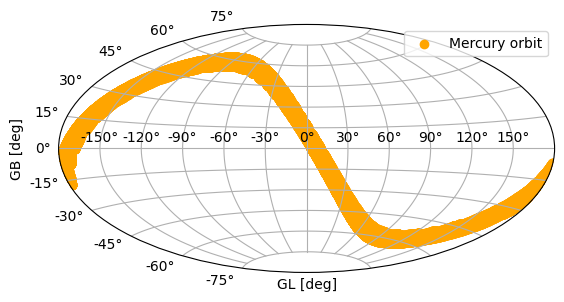

In [ ]:
# Plotting the coordinates

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange', label = 'Mercury orbit')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# creating a Time object to convert times easily
times_jupiter = Time(jd_jupiter,format='jd')

# converting to MJD:
times_jupiter_mjd = times_jupiter.mjd

# converting to IJD
times_jupiter_ijd = times_jupiter_mjd - 51544
print(times_jupiter_ijd)



[1021.   1021.25 1021.5  ... 8764.5  8764.75 8765.  ]


In [ ]:
# Getting scw times:
tstart_scw = scw[1].data['TStart']
tend_scw = scw[1].data['TEnd']
n_scw = len(tstart_scw)


valid_times = np.where((tstart_scw >= times_jupiter_ijd.min()) & (tstart_scw <= times_jupiter_ijd.max()))

# Create a SmoothSphereBivariateSpline for longitude and latitude
interp_spline = SmoothSphereBivariateSpline(times_jupiter_ijd, gl_jupiter, gb_jupiter)

# Interpolate Jupiter positions for each INTEGRAL observation timestamp
interp_gl = interp_spline(tstart_scw[valid_times], tstart_scw[valid_times], grid=False)[:,0]  # Longitude
interp_gb = interp_spline(tstart_scw[valid_times], tstart_scw[valid_times], grid=False)[:,1]  # Latitude

ValueError: theta should be between [0, pi]

In [ ]:
# getting scw times:
tstart_scw = scw[1].data['TStart']
tend_scw = scw[1].data['TEnd']

n_scw = len(tstart_scw)


valid_times = np.where((tstart_scw >= times_jupiter_ijd.min()) & (tstart_scw <= times_jupiter_ijd.max()))

#Interolation
interp_longitude = UnivariateSpline(times_jupiter_ijd, gl_jupiter, k=5, s=0)
interp_latitude = UnivariateSpline(times_jupiter_ijd, gb_jupiter, k=5, s=0)

# Interpolate Jupiter positions for each INTEGRAL observation timestamp
interp_gl = interp_longitude(tstart_scw[valid_times])
interp_gb = interp_latitude(tstart_scw[valid_times])







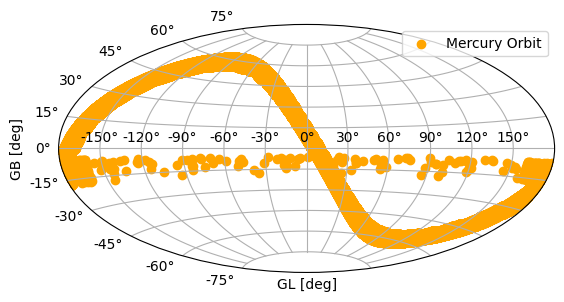

In [ ]:
# Plotting the positions

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(interp_gl),np.deg2rad(interp_gb),marker='o', c='orange', label = 'Mercury Orbit')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()
plt.legend()
plt.show()

In [ ]:

jupiter_cross_idx = []

# length of scw file (number of observations)
n_scw = len(tstart_scw)

# length of calculated jupiter positions
n_jupiter = len(interp_gb)

print(n_jupiter)

for i in tqdm(range(n_jupiter)):
         if angular_distance(lon_sc[i],lat_sc[i], interp_gl[i], interp_gb[i]) <= fov_threshold:
                jupiter_cross_idx.append(i)

len(jupiter_cross_idx)

194801


  0%|          | 0/194801 [00:00<?, ?it/s]

5

In [ ]:
def filter_pointings_for_jupiter(scw_file, jupiter_positions, threshold, new_filename, overwrite=True):
    f = fits.open(scw_file)
    cs_f = []
    for col_name in f[1].columns.names:
        c_tmp = fits.Column(name=col_name,
                            array=f[1].data[col_name][jupiter_cross_idx],
                            format=f[1].columns[col_name].format,
                            unit=f[1].columns[col_name].unit)
        cs_f.append(c_tmp)
    # Write filtered pointings to a new file
    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename, overwrite=overwrite)

    f.close()


In [ ]:
filter_pointings_for_jupiter(data_path+scw_file,jupiter_cross_idx,16,data_path+'scw_Mercury_obs.fits')

In [ ]:
# now reading the just-created file in again to see what is the result
scw_Jupiter = fits.open(data_path+'scw_Mercury_obs.fits')

In [ ]:
ra_sc_new = scw_Jupiter[1].data['RA_SCX']
dec_sc_new = scw_Jupiter[1].data['DEC_SCX']

coords_sc_new = SkyCoord(ra=ra_sc_new,dec=dec_sc_new,unit='deg')

lon_sc_new = coords_sc_new.galactic.l.value
lon_sc_new[lon_sc_new > 180] -= 360
lat_sc_new = coords_sc_new.galactic.b.value

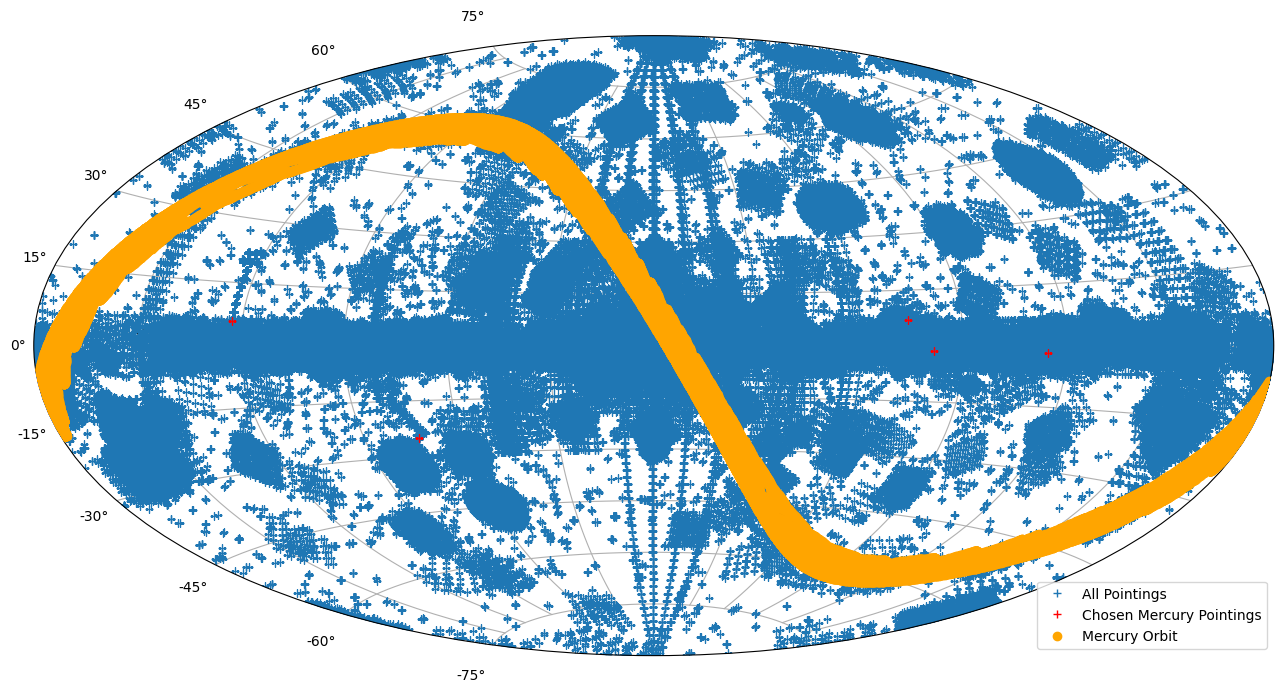

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(projection='aitoff')

# Plot all pointings
plt.plot(np.deg2rad(lon_sc), np.deg2rad(lat_sc), '+', label='All Pointings')

# Plot chosen pointings coinciding with
plt.plot(np.deg2rad(lon_sc_new), np.deg2rad(lat_sc_new), 'r+', label='Chosen Mercury Pointings')

# Plot Jupiter position (for reference)
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange', zorder=100, label = 'Mercury Orbit')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Now that we have the pointings that can see Jupiter we will need to consider that Jupiter might be very weak,
# so that we will try to avoid bright sources; Thus we will remove the pointings near the galactic center and the anti-galactic center.
#The anti-galactic center is the crab nebula so we need to find where it is and remove the pointings that are within 30 deg of the Crab.
# The same will happen for the galactic-center.

l_Crab, b_Crab = 184.5574843227357-360, -05.7843392171240 #position of the crab.

scw_filtered = fits.open(data_path+"scw_Neptune_obs.fits")
scw_filtered.info()

# looking into the pointing distribution:
ra_sc_f = scw_filtered[1].data['RA_SCX']
dec_sc_f = scw_filtered[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc_f = SkyCoord(ra=ra_sc_f,dec=dec_sc_f,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc_f = coords_sc_f.galactic.l.value
# converting from 0..360 to -180..180
lon_sc_f[lon_sc_f > 180] -= 360
lat_sc_f = coords_sc_f.galactic.b.value
revs_f = scw_filtered[1].data['OrbitRevFrac']
revs_unit_f = scw_filtered[1].columns['OrbitRevFrac'].unit


crab_dist = angular_distance(l_Crab,b_Crab,lon_sc_f,lat_sc_f) #all crab angular distances.


Filename: ./scw_Neptune_obs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   741R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


Text(0, 0.5, 'Angular distance to Crab [deg]')

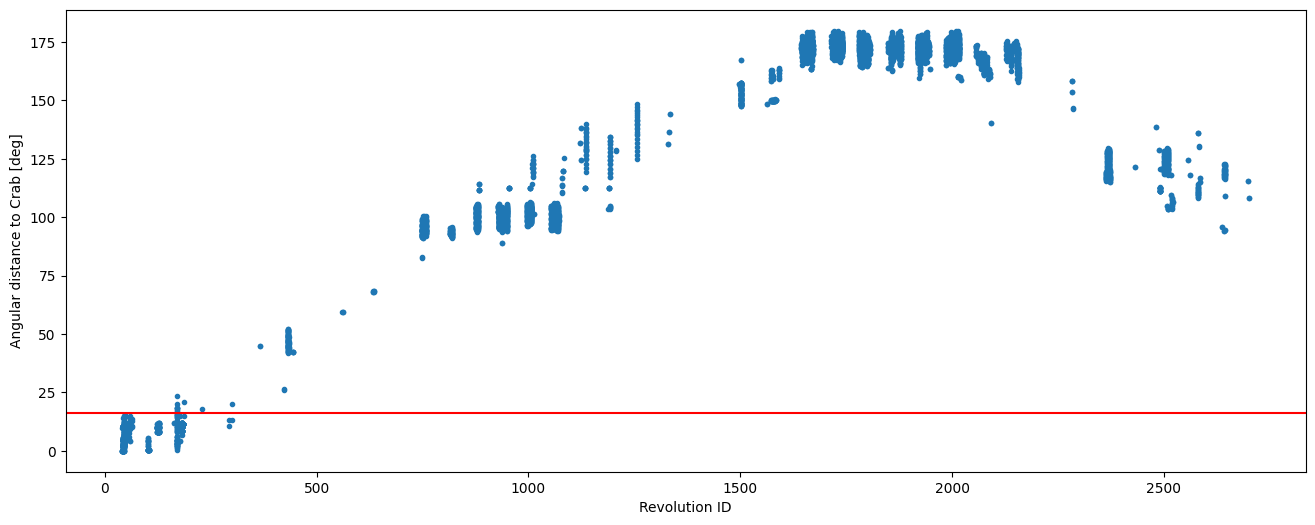

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(revs_f,crab_dist,'.')
plt.axhline(fov_threshold,linestyle='-',color='red')
plt.xlabel('Revolution ID')
plt.ylabel('Angular distance to Crab [deg]')

In [ ]:
crab_obs_idx = np.where(crab_dist > 30)[0]

def filter_scw(scw_file,filter_idx,new_filename,overwrite=True):

    f = fits.open(scw_file)

    used_columns = []
    for i in range(len(f[1].columns)):
        used_columns.append(f[1].columns[i].name)

    cs_f = []
    for i in range(len(used_columns)):

        c_tmp = fits.Column(name=used_columns[i],
                            array=f[1].data[used_columns[i]][filter_idx],
                            format=f[1].columns[used_columns[i]].format,
                            unit=f[1].columns[used_columns[i]].unit)

        cs_f.append(c_tmp)

    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename,overwrite=overwrite)

    f.close()


In [ ]:
filter_scw(data_path+"scw_Neptune_obs.fits",crab_obs_idx,data_path+'scw_Neptune_obs_minusCrab.fits')

In [ ]:
swc_minusC =fits.open(data_path+'scw_Neptune_obs_minusCrab.fits')


ra_sc_mC = swc_minusC[1].data['RA_SCX']
dec_sc_mC = swc_minusC[1].data['DEC_SCX']

coords_sc_mC = SkyCoord(ra=ra_sc_mC,dec=dec_sc_mC,unit='deg')

lon_sc_mC = coords_sc_mC.galactic.l.value
lon_sc_mC[lon_sc_mC > 180] -= 360
lat_sc_mC = coords_sc_mC.galactic.b.value

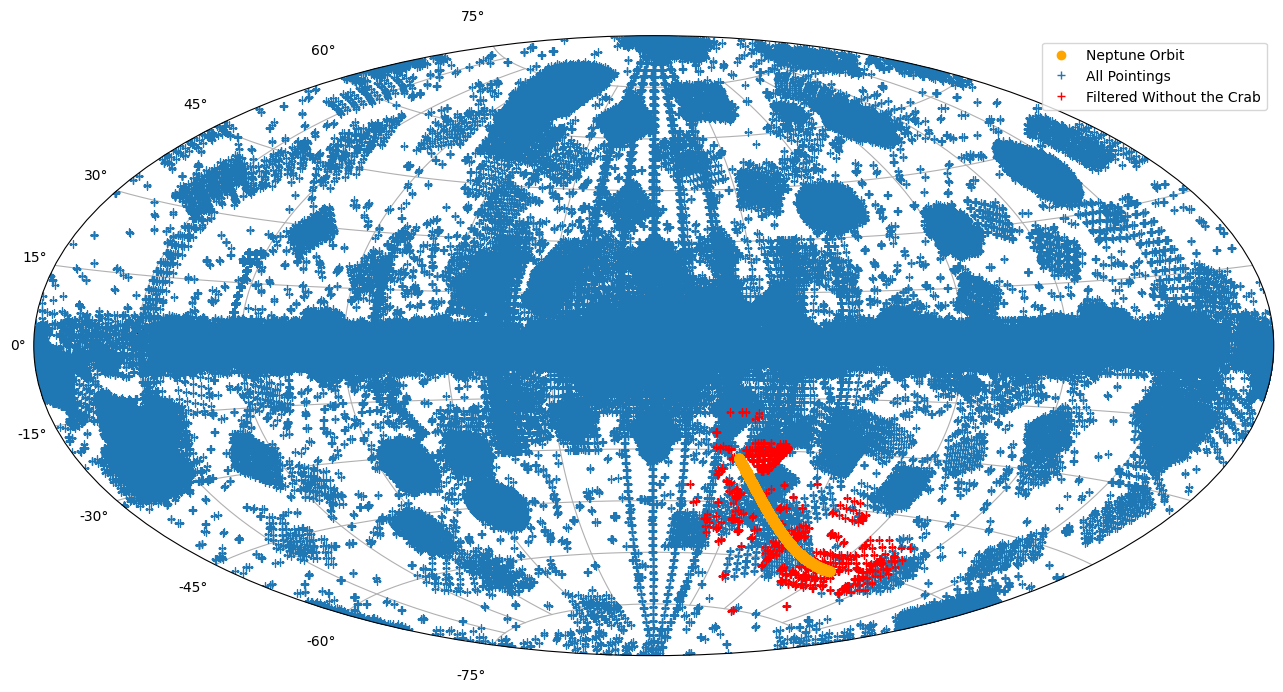

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange', zorder=100, label = 'Neptune Orbit')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_mC),np.deg2rad(lat_sc_mC),'r+',label='Filtered Without the Crab')
plt.legend(loc=1)
plt.legend(loc=1)
plt.grid()

In [ ]:
l_center, b_center = 0, 0 #position of the crab.

scw_filtered_center = fits.open(data_path+"scw_Neptune_obs_minusCrab.fits")
scw_filtered_center.info()

# looking into the pointing distribution:
ra_sc_f_c = scw_filtered_center[1].data['RA_SCX']
dec_sc_f_c = scw_filtered_center[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc_f_c = SkyCoord(ra=ra_sc_f_c,dec=dec_sc_f_c,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc_f_c = coords_sc_f_c.galactic.l.value
# converting from 0..360 to -180..180
lon_sc_f_c[lon_sc_f_c > 180] -= 360
lat_sc_f_c = coords_sc_f_c.galactic.b.value
revs_f_c = scw_filtered_center[1].data['OrbitRevFrac']
revs_unit_f_c = scw_filtered_center[1].columns['OrbitRevFrac'].unit


center_dist = angular_distance(l_center,b_center,lon_sc_f_c,lat_sc_f_c) #all galactic center angular distances.


Filename: ./scw_Neptune_obs_minusCrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   741R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


In [ ]:
center_idx = np.where(center_dist > 30)[0]

def filter_scw(scw_file,filter_idx,new_filename,overwrite=True):

    f = fits.open(scw_file)

    used_columns = []
    for i in range(len(f[1].columns)):
        used_columns.append(f[1].columns[i].name)

    cs_f = []
    for i in range(len(used_columns)):

        c_tmp = fits.Column(name=used_columns[i],
                            array=f[1].data[used_columns[i]][filter_idx],
                            format=f[1].columns[used_columns[i]].format,
                            unit=f[1].columns[used_columns[i]].unit)

        cs_f.append(c_tmp)

    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename,overwrite=overwrite)

    f.close()


In [ ]:
filter_scw(data_path+"scw_Neptune_obs_minusCrab.fits",center_idx,data_path+'scw_Neptune_obs_final.fits')

swc_final =fits.open(data_path+'scw_Neptune_obs_final.fits')


ra_sc_final = swc_final[1].data['RA_SCX']
dec_sc_final = swc_final[1].data['DEC_SCX']

coords_sc_final = SkyCoord(ra=ra_sc_final,dec=dec_sc_final,unit='deg')

lon_sc_final = coords_sc_final.galactic.l.value
lon_sc_final[lon_sc_final > 180] -= 360
lat_sc_final = coords_sc_final.galactic.b.value

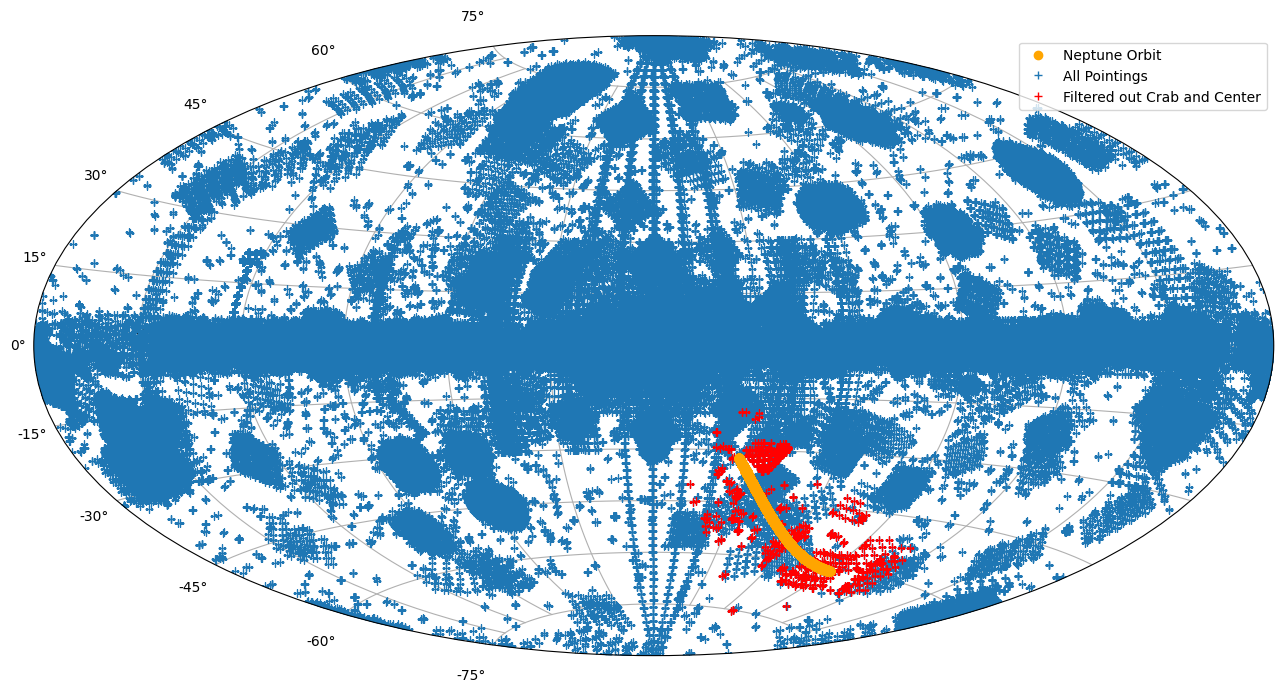

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange', zorder=100, label = 'Neptune Orbit')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_final),np.deg2rad(lat_sc_final),'r+',label='Filtered out Crab and Center')
plt.legend(loc=1)
plt.grid()

In [ ]:
center_idx = np.where(center_dist > 40)[0]

filter_scw(data_path+"scw_Neptune_obs_minusCrab.fits",center_idx,data_path+'scw_Neptune_obs_final40.fits')

swc_final40 =fits.open(data_path+'scw_Neptune_obs_final40.fits')


ra_sc_final40 = swc_final40[1].data['RA_SCX']
dec_sc_final40 = swc_final40[1].data['DEC_SCX']

coords_sc_final40 = SkyCoord(ra=ra_sc_final40,dec=dec_sc_final40,unit='deg')

lon_sc_final40 = coords_sc_final40.galactic.l.value
lon_sc_final40[lon_sc_final40 > 180] -= 360
lat_sc_final40 = coords_sc_final40.galactic.b.value

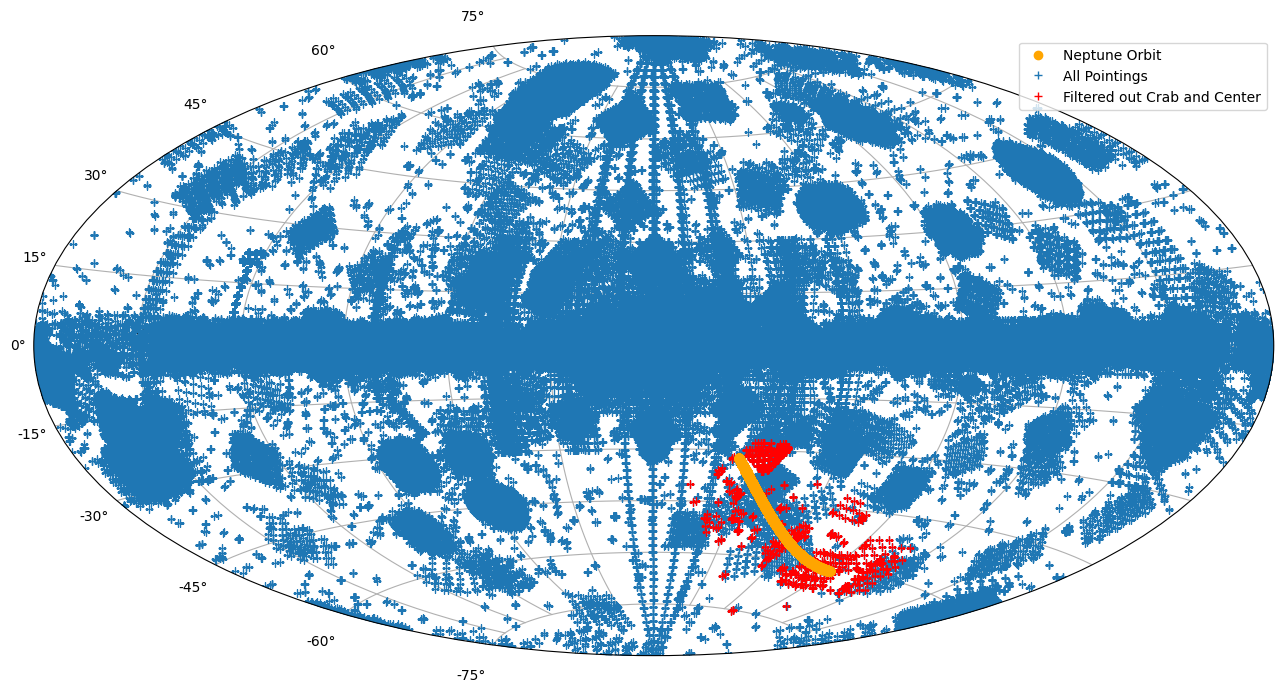

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange', zorder=100, label = 'Neptune Orbit')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_final40),np.deg2rad(lat_sc_final40),'r+',label='Filtered out Crab and Center')
plt.legend(loc=1)
plt.grid()